In [1]:
import numpy as np
import scipy.linalg as spla
from sif.kernels import MaternKernel
from sif.models import GaussianProcess
from sif.samplers import EllipticalSliceSampler

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Create random data that is measured with a small amount of noise.

In [3]:
X = np.random.uniform(size=(50, 1))
y = np.random.normal(13. * np.cos(10.*X) / (X + 1.), 1.).ravel()

We define a Gaussian process likelihood function of the latent parameters of our model given the observational data. In particular, our likelihood is a function of the kernel length scales and amplitude, the noise level of the target, and the inferred global minimum.

In [4]:
def log_likelihood_func(f):
    # Extract Gaussian process latent parameters.
    length_scales = np.exp(f[:1])
    amplitude = np.exp(f[-3])
    noise_level = np.exp(f[-2])
    eta = -(np.exp(f[-1]) - y.min())
    assert eta < y.min() and not np.isnan(eta)
    # Compute a new target variable.
    g = np.sqrt(2. * (y - eta))
    gp = GaussianProcess(MaternKernel(length_scales, amplitude), 1e-5)
    gp.fit(X, g)
    # Now approximate the likelihood.
    m_g, _ = gp.predict(X)
    K_f = (gp.K * m_g).T * m_g + noise_level
    L_f = spla.cholesky(K_f, lower=True)
    m_f = eta + 0.5 * m_g**2
    yp = y - m_f
    alpha = spla.cho_solve((L_f, True), yp)
    
    return -1 * (
        0.5 * yp.dot(alpha) + 
        np.sum(np.log(np.diag(L_f))) + 
        0.5 * X.shape[0] * np.log(2.*np.pi)
    )

We use an elliptical slice sampler to infer a distribution over the function's minimum (among other parameters). For the elliptical slice sampler, we assume a fully independent multivariate Gaussian. We adjust the mean and covariance of the minimum to more accurately reflect the prior belief.

In [5]:
n_samples = 1000
mean = np.zeros((4, ))
covariance = np.diag(np.ones((4, )) * 5.)

In [6]:
sampler = EllipticalSliceSampler(mean, covariance, log_likelihood_func)
samples = np.exp(sampler.sample(n_samples, burnin=1000))
samples[:, -1] = -(samples[:, -1] - y.min())

Now we visualize the distribution of the minimum. 

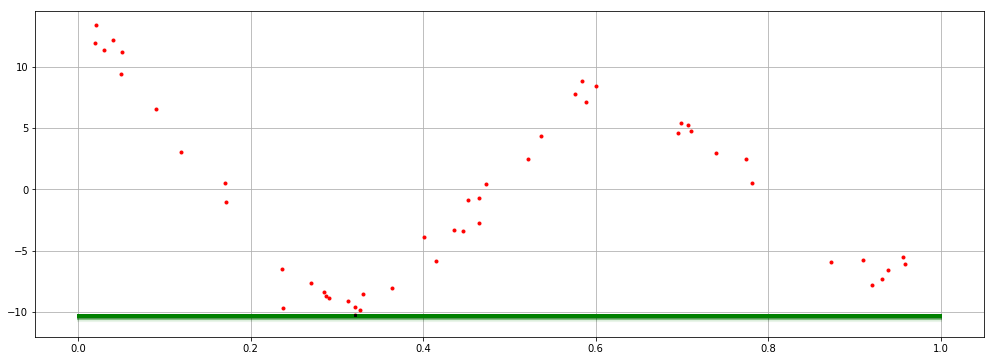

In [7]:
plt.figure(figsize=(17, 6))
plt.plot(X.ravel(), y.ravel(), "r.")
for i in range(min(n_samples, 1000)):
    plt.plot([0., 1.], [samples[i, -1], samples[i, -1]], "g-", alpha=1. / 100)
plt.grid()
plt.legend(fontsize=12)
plt.show()

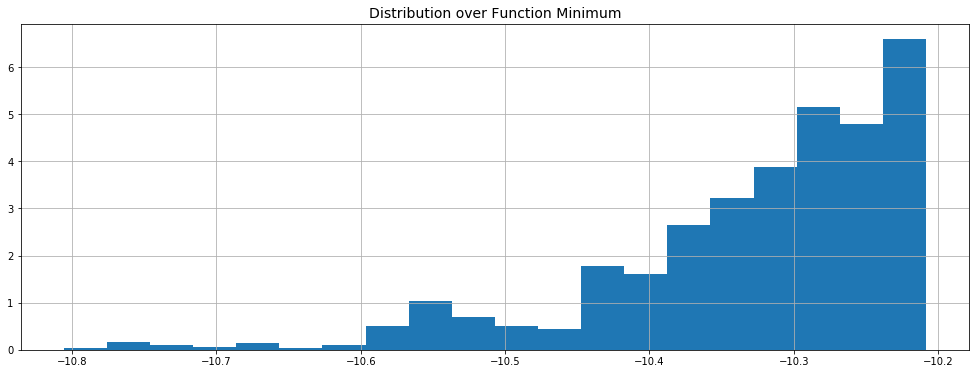

In [9]:
plt.figure(figsize=(17, 6))
plt.hist(samples[:, -1], bins=20, normed=True)
plt.title("Distribution over Function Minimum", fontsize=14)
plt.grid()
plt.show()